In [1]:
import re, math
import operator
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from random import randint
import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
# import ipynb.fs.defs.TweetTextHandler as tweetTextHandler
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')
# import plotly.offline as offline
# offline.init_notebook_mode(connected=True)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [97]:
def replace_by_symbols(txt):
#     txt = re.sub(r"https\S+", '<URL>', txt)
#     txt = re.sub(r"http\S+", '<URL>', txt)
#     txt = re.sub(r"pic.twitter.com\S+", '<URL>', txt)
#     txt = re.sub(r"twitter.com/\S+", '<URL>', txt)
#     txt = re.sub(r"\S+/\S+", '<URL>', txt)
#     txt = re.sub(r"@\S+", '<USERMENTION>', txt)
#     txt = re.sub(r"#\S+", '<HASHTAG>', txt)
    txt = re.sub(r"https\S+", '', txt)
    txt = re.sub(r"http\S+", '', txt)
    txt = re.sub(r"pic.twitter.com\S+", '', txt)
    txt = re.sub(r"twitter.com/\S+", '', txt)
    txt = re.sub(r"\S+/\S+", '', txt)
    txt = re.sub(r"@\S+", '', txt)
    txt = re.sub(r"#\S+", '', txt)
    txt = re.sub(r"idk", 'i does not know', txt)   # idk: i don't know
    txt = re.sub(r"tho", 'though', txt)   # tho
    txt = re.sub(r"don", 'does not', txt)
    txt = re.sub(r"ve", '', txt)
    txt = re.sub(r"didn", 'did not', txt)
    txt = re.sub(r"wasn", 'was not', txt)
    return txt

In [3]:
def getWordsDict(texts):
    global stop_words
    wordDict = dict()
    stopwordDict = dict()
    stopwordTweetCount = 0
    tweet_length = 0
    tknzr = TweetTokenizer()
    aaa = texts
    length = len(texts)
    for txt in texts:
        stopwordFlag = False
        try:
            txt = filterMethods.filter_tweet_by_re(txt)
            tweet_length += len(txt)
            for token in tknzr.tokenize(txt):
                if token.isdigit():
                    pass
                elif token in stop_words:
                    stopwordDict[token] = stopwordDict.get(token, 0) + 1
                    stopwordFlag = True
                else:
                    wordDict[token] = wordDict.get(token, 0) + 1
            if stopwordFlag:
                stopwordTweetCount += 1
        except Exception as e:
            print(e)
    return wordDict, stopwordDict, stopwordTweetCount, round(tweet_length/length,1)

# Initialize Users

In [87]:
patients = dict()
ordinarys = dict()
with open('../0_dataset/patient_ids') as r:
    for patient in r.readlines()[:100]:
        patient = patient.strip()
        patients[patient] = peopleInfo.Patient(patient)
with open('../0_dataset/ordinary_ids') as r:
    for ordinary in r.readlines()[:100]:
        ordinary = ordinary.strip()
        ordinarys[ordinary] = peopleInfo.Ordinary(ordinary)

# Filter Users

In [89]:
patients = filterMethods.filter_user_by_tweet_number(patients)
ordinarys = filterMethods.filter_user_by_tweet_number(ordinarys)

Remove users:[]
Remove users:[]


# Compare Stopwords between Ordinary People and Patients

In [7]:
patients_total = [0, 0, 0, 0]
for key in patients:
    _w, _s, _sc, _tl = getWordsDict(patients[key].getText())
    patients_total[0] += sum(_s.values())
    patients_total[1] += _sc
    patients_total[2] += len(patients[key].inRangeDf)
    patients_total[3] += _tl
    
patients_total[3] = round(patients_total[3]/len(patients),1)

# 0:Stopwords總數/ 1:含有stopwords的發文總數/ 2:（時間內的）發文總數/ 3:平均發文長度

In [8]:
ordinarys_total = [0, 0, 0, 0]
for key in ordinarys:
    _w, _s, _sc, _tl = getWordsDict(ordinarys[key].getText())
    ordinarys_total[0] += sum(_s.values())
    ordinarys_total[1] += _sc
    ordinarys_total[2] += len(ordinarys[key].inRangeDf)
    ordinarys_total[3] += _tl
    
ordinarys_total[3] = round(ordinarys_total[3]/len(ordinarys),1)
# 0:Stopwords總數/ 1:含有stopwords的推文總數/ 2:（時間內的）推文總數/ 3:平均發文長度

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



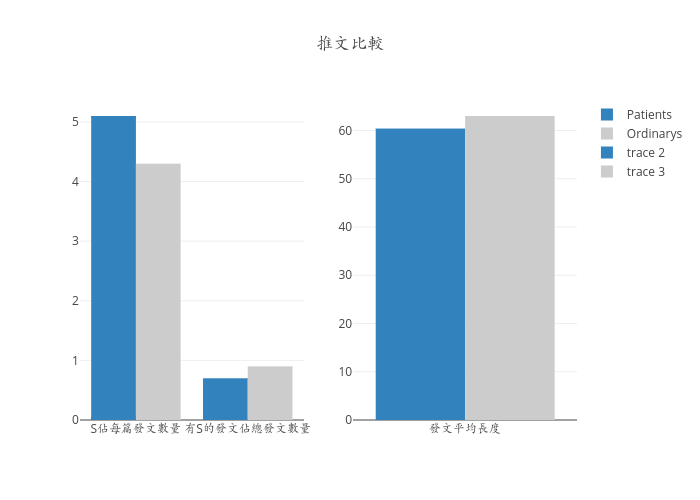

In [9]:
trace1_p = go.Bar(x=['S佔每篇發文數量', '有S的發文佔總發文數量'],
                  y=[round(patients_total[0]/patients_total[1],1), round(patients_total[1]/patients_total[2],1)],
                  name='Patients',
                  marker=dict(color='rgb(49,130,189)'))

trace1_o = go.Bar(x=['S佔每篇發文數量', '有S的發文佔總發文數量'],
                y=[round(ordinarys_total[0]/ordinarys_total[1],1), round(ordinarys_total[1]/ordinarys_total[2],1)],
                name='Ordinarys',
                marker=dict(color='rgb(204,204,204)'))

trace2_p = go.Bar(x=['發文平均長度'],
                y=[patients_total[3]],
                marker=dict(color='rgb(49,130,189)'))

trace2_o = go.Bar(x=['發文平均長度'],
                y=[ordinarys_total[3]],
                marker=dict(color='rgb(204,204,204)'))

fig = plotly.tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace1_p,1,1)
fig.append_trace(trace1_o,1,1)
fig.append_trace(trace2_p,1,2)
fig.append_trace(trace2_o,1,2)
fig['layout'].update(title='推文比較')
# fig = go.Figure(data=data, layout=layout)
py.image.save_as(fig, filename='img/stopwords_compare.png')
display(Image(filename='img/stopwords_compare.png'))
# py.iplot(fig)

# Prepare Data

In [98]:
base_texts = []
group_texts = []

for key in patients.keys():
    group_texts.append(replace_by_symbols('\n'.join(patients[key].getText())))

for key in ordinarys.keys():
    base_texts.append(replace_by_symbols('\n'.join(ordinarys[key].getText())))

corpus = base_texts + group_texts

# TF-IDF Model with Multi-grams

In [99]:
def getTFIDF(base_texts, group_texts, grams, stop_words=True):
    print('Get Tf-idf with grams:{0}'.format(grams))
    low = grams[0]
    high = grams[1]
    text_model = dict()
    vectorizer = TfidfVectorizer(stop_words="english",ngram_range = (low,high), min_df=1)
    X = vectorizer.fit_transform(base_texts+group_texts)
    Y = np.array([0] * len(base_texts) + [1]*len(group_texts), dtype=int)
    text_model['X'] = X
    text_model['Y'] = Y
    text_model['vectorizer'] = vectorizer
    return text_model

In [100]:
def getTopFeatures(vectorizer, classifier, k=50):
    vector2word = vectorizer.get_feature_names()
    feature_indicies = np.argsort(classifier.feature_importances_)
    top_words = []
    for i in range(50):
        vector = feature_indicies[-i-1]
        word = vector2word[vector]
        top_words.append(word)
    return top_words

# Train RandomForest Classifier

In [101]:
grams = [[1,1],[1,2],[2,2]]
top_words_grams = []
for i in range(len(grams)):
    text_model = getTFIDF(base_texts, group_texts, grams=grams[i])
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    classifier.fit(text_model['X'],text_model['Y'])
    top_words = getTopFeatures(text_model['vectorizer'],classifier)
    top_words_grams.append(top_words)

Get Tf-idf with grams:[1, 1]
Get Tf-idf with grams:[1, 2]
Get Tf-idf with grams:[2, 2]


# Top 50: Unigram

In [102]:
top_words_grams[0]

['depression',
 'diagnosed',
 'fuck',
 'pain',
 'tried',
 'bad',
 'cute',
 'man',
 'sad',
 'real',
 'attention',
 'dead',
 'started',
 'happy',
 'thank',
 'heart',
 'trying',
 'li',
 'problem',
 'life',
 'mind',
 'hi',
 'die',
 'need',
 'whater',
 'en',
 'extremely',
 'broken',
 'god',
 'eryone',
 'telling',
 'women',
 'treat',
 'honestly',
 'tweet',
 'tears',
 'sick',
 'weird',
 'yes',
 'major',
 'took',
 'really',
 'erything',
 'inside',
 'soon',
 'idea',
 'hard',
 'gi',
 'sorry',
 'chicken']

# Top 50: Unigram and Bigrams

In [103]:
top_words_grams[1]

['diagnosed',
 'depression',
 'piece',
 'hard',
 'literally',
 'gis',
 'fully',
 'broken',
 'feel',
 'tweet',
 'gone',
 'delete',
 'cares',
 'paid',
 'adorable',
 'google',
 'issues',
 'sleep',
 'asking',
 'certain',
 'normal',
 'life',
 'did en',
 'does',
 'fuck',
 'care',
 'protect',
 'lose',
 'people',
 'shall',
 'new',
 'wow',
 'big',
 'wanna',
 'real',
 'listening',
 'll',
 'better',
 '2017',
 'wish',
 'like just',
 'hurt',
 'honestly',
 'knew',
 'learned',
 'sad',
 'like',
 'floor',
 'sick',
 'reasons']

# Top 50: Bigrams

In [104]:
top_words_grams[2]

['does know',
 'diagnosed depression',
 'ery night',
 'did want',
 'ice cream',
 'know ll',
 'just want',
 'just got',
 'ha idea',
 'oh god',
 'feel better',
 '13 reasons',
 'ha does',
 'did en',
 'fuck did',
 'does like',
 'day lo',
 'good just',
 'en care',
 'really really',
 'like does',
 'want make',
 'just ha',
 'does feel',
 'gonna ha',
 'ha said',
 'just stop',
 'know lo',
 'way lo',
 'im gonna',
 'doesn know',
 'fall lo',
 'does note',
 'ery single',
 'feel like',
 'just doesn',
 'll make',
 'long time',
 'did wrong',
 'ha lo',
 'good night',
 'got diagnosed',
 'better er',
 'does think',
 'know just',
 'time ha',
 'true lo',
 'best thing',
 'ha ha',
 'ha diagnosed']

# Get Precision

In [111]:
def getPrecision(base_texts, group_texts, text_model, clf = "default", n_fold=10):
    X = text_model['X']
    Y = text_model['Y']
    sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
    if clf == 'default':
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        
    precisions = []
    for train_index, test_index in sss:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        classifier = classifier.fit(X_train, Y_train)
        score = classifier.score(X_test, Y_test)
        precisions.append(score)
    return precisions

In [112]:
precisions = getPrecision(base_texts,group_texts,text_model)

In [113]:
np.mean(precisions)

0.76315789473684204

# Stopwords Pattern

In [116]:
with open ('stopwords_pattern_group', 'a') as open_file:
    tknzr = TweetTokenizer()
    pattern_position = dict()
    for txts in group_texts:
        for txt in txts.split('\n'):
            position = []
            for i, word in enumerate(replace_by_symbols(txt)):
                if word in stop_words:
                    position.append(i)
            open_file.write('{0}\n'.format(position))

In [117]:
with open ('stopwords_pattern_base', 'a') as open_file:
    tknzr = TweetTokenizer()
    pattern_position = dict()
    for txts in base_texts:
        for txt in txts.split('\n'):
            position = []
            for i, word in enumerate(replace_by_symbols(txt)):
                if word in stop_words:
                    position.append(i)
            open_file.write('{0}\n'.format(position))

In [118]:
swg = dict()
swg_len = 0
with open ('stopwords_pattern_group') as open_file:
    for line in open_file.readlines():
        swg_len += 1
        a = list(line.strip()[1:-1].split(', '))
        for i in range(len(a)):
            try:
                difference = abs(int(a[i]) - int(a[i+1]))
                swg[difference] = swg.get(difference, 0) + 1 
            except (IndexError, ValueError) as e:
#                 if e.args[0] == "invalid literal for int() with base 10: ''":
#                     print(line)
                continue

In [119]:
swb = dict()
swb_len = 0
with open ('stopwords_pattern_base') as open_file:
    for line in open_file.readlines():
        swb_len += 1
        a = list(line.strip()[1:-1].split(', '))
        for i in range(len(a)):
            try:
                difference = abs(int(a[i]) - int(a[i+1]))
                swb[difference] = swb.get(difference, 0) + 1 
            except (IndexError, ValueError) as e:
                continue

In [138]:
for key in swb.keys():
    swb[key] = swb[key]/swb_len
sorted_swb = sorted(swb.items(), key=operator.itemgetter(1), reverse=True)

for key in swg.keys():
    swg[key] = swg[key]/swg_len
sorted_swg = sorted(swg.items(), key=operator.itemgetter(1), reverse=True)

In [157]:
trace11 = go.Bar(
    x=[ele[0] for ele in sorted_swb[:10]],
    y=[ele[1] for ele in sorted_swb[:10]],
    name='Ordinary',
    marker=dict(color='rgb(204,204,204)'))

trace22 = go.Bar(
    x=[ele[0] for ele in sorted_swg[:10]],
    y=[ele[1] for ele in sorted_swg[:10]],
    name='Patient',
    marker=dict(color='rgb(49,130,189)'))

fig12 = plotly.tools.make_subplots(rows=1, cols=2)
fig12.append_trace(trace22,1,1)
fig12.append_trace(trace11,1,2)
py.iplot(fig12)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [154]:
trace1 = go.Bar(
    x=[ele[0] for ele in sorted_swb[:10]],
    y=[abs(1/math.log(ele[1])) for ele in sorted_swb[:10]],
    name='Ordinary',
    marker=dict(color='rgb(204,204,204)')
)
trace2 = go.Bar(
    x=[ele[0] for ele in sorted_swg[:10]],
    y=[abs(1/math.log(ele[1])) for ele in sorted_swg[:10]],
    name='Patient',
    marker=dict(color='rgb(49,130,189)')
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [52]:
pattern = re.compile(r"tho")

In [53]:
for i, txts in enumerate(group_texts):
    for txt in txts.split('\n'):
        if pattern.match(txt):
            print('[{0}] {1}'.format(i, txt))

[0] those look really cool :D
[6] those don't count 
[17] thought the album was out 
[39] those are definitely worth the money. I completely understand.
[47] thought you were coming at me, but i apologize and deleted the tweet.
[47] those are boots
[47] thought someone contacted his mom and got him away and shit but he's back at it.
[47] those people deserve nothing.
[47] those boots are so cute omg
[47] those were the cookies i got last night.
[61] thought this was thinspo !
[68] thoughts on thoughts — Uthoughts   /167752389?t=1498127183 …
[68] thoughs on juan miguel  work? — I like him! He is talented and quite vocal and rela...   /167722620?t=1498114218 …
[68] thoughts on Jake Zyrus? — HE IS NOW MY HEADCANON LARS   /166699748?t=1497971548 …
[68] thoughts on hamilton? — Di ko pa rin natatapos but as a writer-slash-makata...   /166266870?t=1497959875 …
[68] thoughts on this???   ... — what the FUCK is HAPPENING   /162086521?t=1497273750 …
[68] thoughts about zizek? — He's great and al

In [105]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '